#  Intel Image Classification. 
## Image Scene Classification of Multiclass. 

## Modeling with inception_v3

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings('ignore')

### Image preprocessing

In [57]:
train_path = 'Dataset - Large\seg_train'
valid_path = 'Dataset - Large\seg_test'
test_path = 'Dataset - Large\seg_pred'

#### Data Augmentation

In [58]:
traindatagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_batches=traindatagen.flow_from_directory(directory=train_path, target_size=(150,150), batch_size=128)

Found 14034 images belonging to 6 classes.


**Observations:**
1. Overfitting is observed in modelling
2. Data Augmentaion is done to reduce overfitting
3. model will be trained on images of size 150 * 150

In [4]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_batches = valid_datagen.flow_from_directory(directory=valid_path,shuffle = True, target_size=(150,150), batch_size=128)


Found 3000 images belonging to 6 classes.


In [42]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_batches = test_datagen.flow_from_directory(directory=test_path,shuffle = True, target_size=(150,150), batch_size=128)

Found 84 images belonging to 1 classes.


**Observations:**
1. Data Augmentation that is done to train set should not be repeated to validation and test set.
2. Rescaling should be done to validation and test set as well.
3. Test batches are not shuffled. This will help in predicting class for each image in test set.

## Pretrained InceptionV3 model

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
image_width, image_height = 150,150
Inception = InceptionV3(input_shape=(image_width,image_height,3),include_top=False, weights="imagenet")
Inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


**Observations:**
1. making include_top=False, gives us the flexibility to train the model with images size pf our choice
2. weights are imported from imagenet

## Finetuning the model

In [7]:
for layer in Inception.layers:
    layer.trainable = False

In [8]:
# leaving the last few layers
last_layer = Inception.get_layer('mixed7')
last_output = last_layer.output

In [9]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
x = Flatten()(last_output)
do=Dropout(0.3)(x)
x  = Dense(512 , activation='relu')(do)
x=Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)
model = Model(inputs=Inception.input, outputs=x)

**Observations:**
1. First all the layers of model are frozen
2. Then all the layers after mixed7 are removed
3. Flatten layer is added followed by two dense layers
4. Last layer is softmax and contain 6 units, because we have 6 classes of images

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy', metrics = ['acc'])
filepath="weights_inception_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',save_weights_only=False,verbose=0,  save_best_only=True, mode='max')

In [14]:
# rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_delta=1E-7)

## Training the model

In [15]:
# history = model.fit(train_batches,validation_data=valid_batches, epochs=5,callbacks=[checkpoint])
history = model.fit(train_batches,validation_data=valid_batches, epochs=20,callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 110 steps, validate for 24 steps
Epoch 1/20
110/110 [==============================] - 1537s 14s/step - loss: 0.7413 - acc: 0.7283 - val_loss: 0.6820 - val_acc: 0.7760
Epoch 2/20
110/110 [==============================] - 1386s 13s/step - loss: 0.4970 - acc: 0.8234 - val_loss: 0.5284 - val_acc: 0.8227
Epoch 3/20
110/110 [==============================] - 1206s 11s/step - loss: 0.4538 - acc: 0.8363 - val_loss: 0.5786 - val_acc: 0.8173
Epoch 4/20
110/110 [==============================] - 1253s 11s/step - loss: 0.4335 - acc: 0.8405 - val_loss: 0.4735 - val_acc: 0.8417
Epoch 5/20
110/110 [==============================] - 1234s 11s/step - loss: 0.4158 - acc: 0.8489 - val_loss: 0.4642 - val_acc: 0.8480
Epoch 6/20
110/110 [==============================] - 1230s 11s/step - loss: 0.4147 - acc: 0.8516 - val_loss: 0.4858 - val_acc: 0.8453
Epoch 7/20
110/110 [==============================] - 1279s 12s/step - loss: 0.4056 - acc: 0.8490

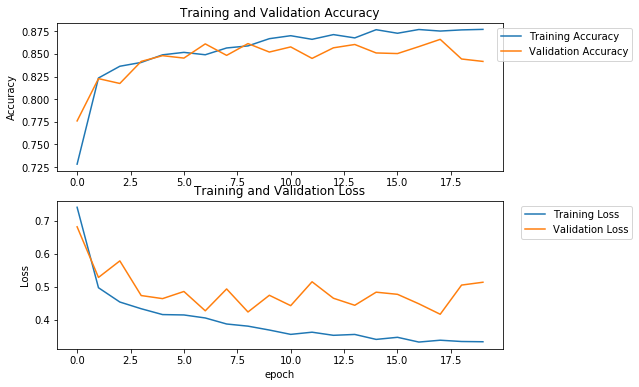

In [18]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Observations:**
1. In the first few iterations the loss/accuracy changes a lot
2. The validation loss/accuracy is comparitivey less stable.

## Plotting confusion matrix

In [31]:
model.save('inceptionModel.h5')

In [32]:
new_model = tf.keras.models.load_model('inceptionModel.h5')

In [44]:
predictionsV = new_model.predict(x=valid_batches, steps=len(valid_batches), verbose=0)

In [49]:
scores = new_model.evaluate(valid_batches, verbose=0)
print("%s: %.2f%%" % (new_model.metrics_names[1], scores[1]*100))

  ...
    to  
  ['...']
acc: 84.17%


**Observations:**
1. After training, the model is saved to an h5 file.
2. The validation accuracy is 84.17%

In [51]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=predictionsV.argmax(axis=1))

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 48  61  89 104  42  93]
 [ 75  60  99 103  46  91]
 [ 74  79 115 129  56 100]
 [ 67  66  99 136  54 103]
 [ 73  74 103 114  60  86]
 [ 63  84  90 112  59  93]]


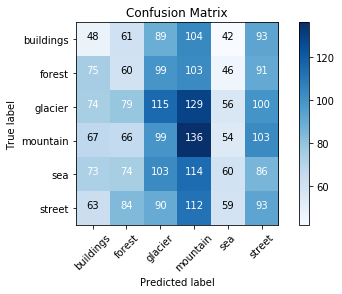

In [55]:
cm_plot_labels = ['buildings','forest','glacier','mountain','sea','street']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**Observations:**
1. The confusion matrix show performance of all classes.
2. Many images are predicted as mountain even if they belong to other classes.
3. The confusion do not show a very good performance of model.

## Prediction on test images

In [33]:
predictions = new_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [34]:
preds_cls_idx = predictions.argmax(axis=-1)

In [35]:
# https://stackoverflow.com/questions/57516673/how-to-perform-prediction-using-predict-generator-on-unlabeled-test-data-in-kera
import numpy as np
idx_to_cls = {v: k for k, v in train_batches.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_batches.filenames, preds_cls))

In [36]:
train_batches.class_indices.items()

dict_items([('buildings', 0), ('forest', 1), ('glacier', 2), ('mountain', 3), ('sea', 4), ('street', 5)])

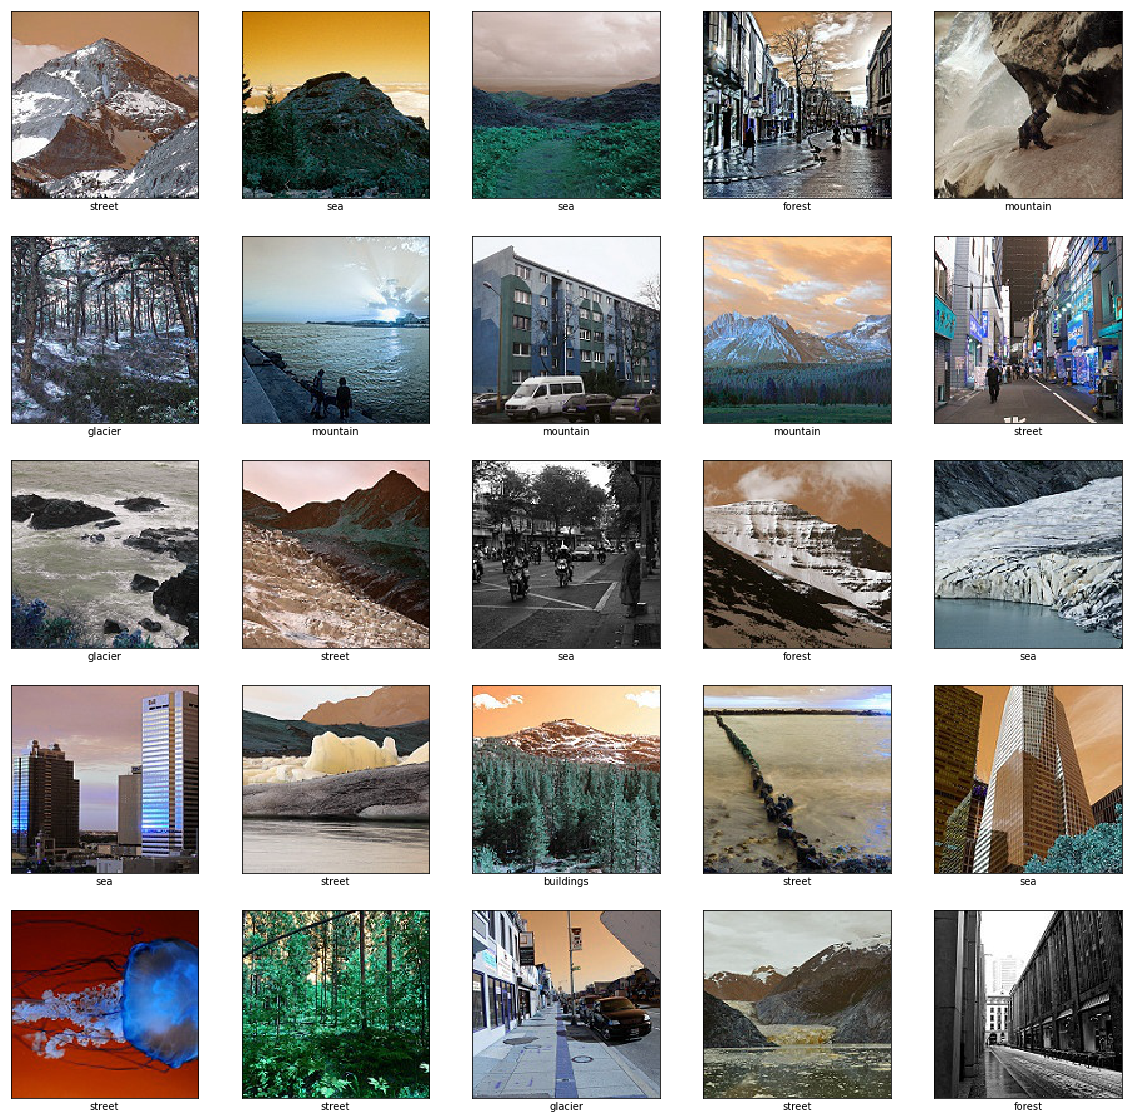

In [37]:
import cv2 as cv
plt.figure(figsize=(20,20))
for i in range(50,75):
    plt.subplot(5,5,i+1-50)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv.imread(r'Dataset - Large\\seg_pred\\'+filenames_to_cls[i][0])
    plt.imshow(img)
    plt.xlabel(filenames_to_cls[i][1])
plt.show()


**Observations:**
1. The class labels for test images is not given. Hence we cant calculate its accuracy.
2. Though the accuracy on validation set is fairly good, the results on test batches are not  good.
3. The classes in this dataset are very similar to classes in imagenet dataset, but still inception model has failed to give good performance on test set